In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

data_dir = "/kaggle/input/lung-disease/Lung X-Ray Image/Lung X-Ray Image/"  
img_size = (224, 224)
batch_size = 32
seed = 42


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3  
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=seed
)


val_test_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=seed
)


val_size = len(val_test_gen) // 2
val_batches = []
test_batches = []

for i, (x, y) in enumerate(val_test_gen):
    if i < val_size:
        val_batches.append((x, y))
    else:
        test_batches.append((x, y))
    if i >= len(val_test_gen) - 1:
        break


def batches_to_dataset(batches):
    imgs = np.concatenate([x for x, _ in batches])
    labels = np.concatenate([y for _, y in batches])
    return tf.data.Dataset.from_tensor_slices((imgs, labels)).batch(batch_size)

val_ds = batches_to_dataset(val_batches)
test_ds = batches_to_dataset(test_batches)

2025-11-04 09:01:22.827457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762246883.232800      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762246883.359619      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 2433 images belonging to 3 classes.
Found 1042 images belonging to 3 classes.


I0000 00:00:1762246910.992273      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762246910.993085      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=seed
)

class_names = list(train_ds.class_indices.keys())
num_classes = len(class_names)
print("Classes:", class_names)


Found 3475 images belonging to 3 classes.
Classes: ['Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [4]:
def build_custom_cnn(input_shape=(224,224,3), num_classes=3):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = build_custom_cnn(num_classes=num_classes)
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1762246919.592044     117 service.cc:148] XLA service 0x7e22dc006bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762246919.593758     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762246919.593785     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762246920.014122     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/109 ━━━━━━━━━━━━━━━━━━━━ 16:44 9s/step - accuracy: 0.3125 - loss: 1.1074

I0000 00:00:1762246925.863185     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/109 ━━━━━━━━━━━━━━━━━━━━ 65s 513ms/step - accuracy: 0.5957 - loss: 0.8519 - val_accuracy: 0.7773 - val_loss: 0.5691
Epoch 2/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 42s 386ms/step - accuracy: 0.7330 - loss: 0.6022 - val_accuracy: 0.7812 - val_loss: 0.5226
Epoch 3/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 42s 384ms/step - accuracy: 0.7626 - loss: 0.5547 - val_accuracy: 0.7832 - val_loss: 0.4526
Epoch 4/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 43s 389ms/step - accuracy: 0.7781 - loss: 0.5385 - val_accuracy: 0.8223 - val_loss: 0.4183
Epoch 5/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 42s 387ms/step - accuracy: 0.7859 - loss: 0.5011 - val_accuracy: 0.8281 - val_loss: 0.3930
Epoch 6/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 42s 389ms/step - accuracy: 0.7929 - loss: 0.4734 - val_accuracy: 0.8457 - val_loss: 0.3799
Epoch 7/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 42s 381ms/step - accuracy: 0.8097 - loss: 0.4551 - val_accuracy: 0.8535 - val_loss: 0.3703
Epoch 8/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 378ms/step - accuracy: 0.8388 - loss: 0.4199 - val

In [5]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False  # freeze all layers

vgg_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

vgg_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_vgg = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 75s 540ms/step - accuracy: 0.3601 - loss: 1.1947 - val_accuracy: 0.6875 - val_loss: 0.9834
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 451ms/step - accuracy: 0.4546 - loss: 1.0489 - val_accuracy: 0.5957 - val_loss: 0.9004
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 447ms/step - accuracy: 0.5846 - loss: 0.9264 - val_accuracy: 0.7148 - val_loss: 0.8371
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 451ms/step - accuracy: 0.6562 - loss: 0.8556 - val_accuracy: 0.7148 - val_loss: 0.8028
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 445ms/step - accuracy: 0.7039 - loss: 0.7803 - val_accuracy: 0.7344 - val_loss: 0.7661
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 444ms/step - accuracy: 0.7450 - loss: 0.7343 - val_accuracy: 0.7305 - val_loss: 0.7224
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 49s 449ms/step - accuracy: 0.7412 - loss: 0.7096 - val_accuracy: 0.7383 - val_loss: 0.6970
Epoch 8/20
109/109 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

📊 Classification Report for Custom CNN:

                 precision    recall  f1-score   support

   Lung_Opacity       0.88      0.86      0.87       161
         Normal       0.86      0.88      0.87       183
Viral Pneumonia       0.98      0.98      0.98       186

       accuracy                           0.91       530
      macro avg       0.91

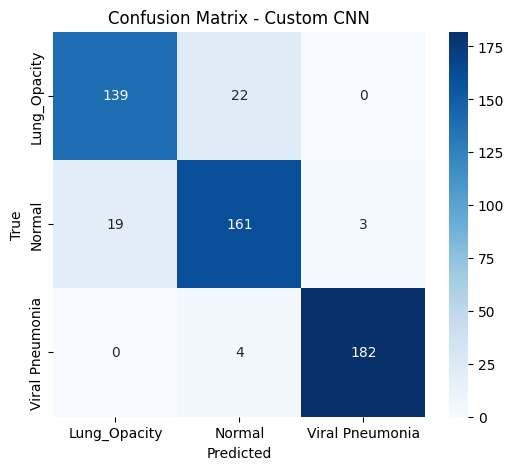

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

📊 Classification Report for VGG19 Fine-Tuned:

                 precision    recall  f1-score   support

   Lung_Opacity       0.79      0.68      0.73       161
         Normal       0.70      0.78      0.73       183
Viral Pneumonia       0.90      0.91      0.91       186

       accuracy                           0.79       530
   

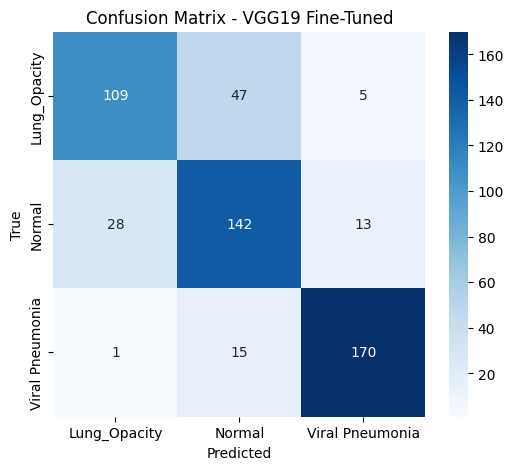

In [6]:
def evaluate_and_report(model, dataset, model_name):
    y_true, y_pred = [], []
    for images, labels in dataset:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    print(f"\n📊 Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate_and_report(cnn_model, test_ds, "Custom CNN")
evaluate_and_report(vgg_model, test_ds, "VGG19 Fine-Tuned")


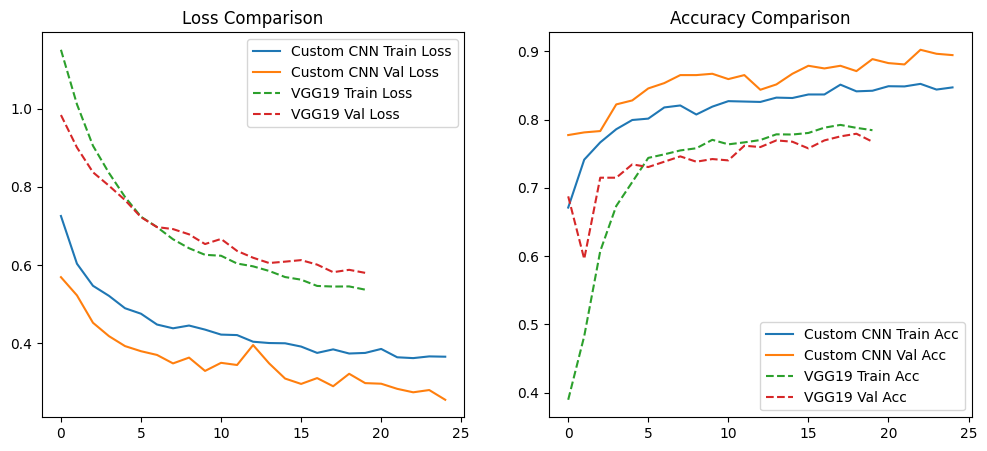

In [7]:
def plot_training_curves(history1, history2, label1, label2):
    plt.figure(figsize=(12,5))
    
    
    plt.subplot(1,2,1)
    plt.plot(history1.history['loss'], label=f'{label1} Train Loss')
    plt.plot(history1.history['val_loss'], label=f'{label1} Val Loss')
    plt.plot(history2.history['loss'], label=f'{label2} Train Loss', linestyle='--')
    plt.plot(history2.history['val_loss'], label=f'{label2} Val Loss', linestyle='--')
    plt.legend(); plt.title('Loss Comparison')
    
    
    plt.subplot(1,2,2)
    plt.plot(history1.history['accuracy'], label=f'{label1} Train Acc')
    plt.plot(history1.history['val_accuracy'], label=f'{label1} Val Acc')
    plt.plot(history2.history['accuracy'], label=f'{label2} Train Acc', linestyle='--')
    plt.plot(history2.history['val_accuracy'], label=f'{label2} Val Acc', linestyle='--')
    plt.legend(); plt.title('Accuracy Comparison')
    
    plt.show()

plot_training_curves(history_cnn, history_vgg, "Custom CNN", "VGG19")
